# Expiration detection model (banana) (Using MobileNetV3_Small)

input image including a banana -> output label (ripeness classification)

ripeness levels:
- 0: green
- 1: overripe
- 2: ripe

## Data Preparation

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras_preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from glob import glob
import pandas as pd

mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


class_names & num_classes

In [ ]:
class_names = ['green', 'overripe', 'ripe']
class_names = sorted(class_names)

num_classes = len(class_names)
print("number of classes: ", num_classes)
print("sorted class_names: ", class_names)

number of classes:  3
sorted class_names:  ['green', 'overripe', 'ripe']


Grab banana ripeness image data

In [ ]:
gdrive_dir = '/content/drive/MyDrive/School/B457 Computer Vision/expiration-images'
custom_images = glob(os.path.join('drive', 'MyDrive', 'School', 'B457 Computer Vision', 'expiration-images', 'banana', '*', '*'))
print('# custom images:', len(custom_images))
custom_images[1]

# custom images: 256


'drive/MyDrive/School/B457 Computer Vision/expiration-images/banana/overripe/overripe20.jpg'

Prepare data into a pd dataframe, so that it can easily be prepared later into a tf Dataset

In [ ]:
# grab list of all image filepaths
all_images = custom_images
# filter to images with the classes we are interested in
all_images = list(filter(lambda x: x.split('/')[-2] in class_names, all_images))
# save the image count for later
image_count = len(all_images)
# create the df with path column
df = pd.DataFrame(dict(path = all_images))
# add class_name column
df['class_name'] = df['path'].map(lambda x: x.split('/')[-2])
# add class column
# (class is the one-hot-encoded version of the class_name, ordered the same as the class_names list)
df['class'] = df['class_name'].map(lambda x: to_categorical(class_names.index(x), num_classes=num_classes).tolist())
# print image count
print(image_count)
# show sample of df
df.sample(3)

256


,path,class_name,class
163,drive/MyDrive/School/B457 Computer Vision/expi...,ripe,"[0.0, 0.0, 1.0]"
63,drive/MyDrive/School/B457 Computer Vision/expi...,green,"[1.0, 0.0, 0.0]"
250,drive/MyDrive/School/B457 Computer Vision/expi...,ripe,"[0.0, 0.0, 1.0]"


Train/test split

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, 
                                   test_size = 0.2, 
                                   random_state = 2022,
                                   stratify = df['class_name'])
print('train', train_df.shape[0], 'test', test_df.shape[0])
train_size = train_df.shape[0]
test_size = test_df.shape[0]

train 204 test 52


In [ ]:
BATCH_SIZE = 8 # small batch size (rather than 32) because of limited data for this model
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

train_generator = ImageDataGenerator(
    brightness_range=[0.1, 0.7], # random brightness range
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.25,       # 25% of the data will be used for validation at end of each epoch
    preprocessing_function=preprocess_input # provided preprocessing function
)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

traingen = train_generator.flow_from_dataframe(train_df,
                                               directory='/content/',
                                               x_col='path',
                                               y_col='class_name',
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), # vgg-16 takes images in 224x224
                                               color_mode='rgb', # force any grayscale images to rgb
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_names,
                                               subset='training',
                                               shuffle=True,
                                               seed=0)

validgen = train_generator.flow_from_dataframe(train_df,
                                               directory='/content/',
                                               x_col='path',
                                               y_col='class_name',
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), # vgg-16 takes images in 224x224
                                               color_mode='rgb', # force any grayscale images to rgb
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_names,
                                               subset='validation',
                                               shuffle=True,
                                               seed=0)

testgen = test_generator.flow_from_dataframe(test_df,
                                             directory='/content/',
                                             x_col='path',
                                             y_col='class_name',
                                             target_size=(IMG_WIDTH, IMG_HEIGHT), # vgg-16 takes images in 224x224
                                             color_mode='rgb', # force any grayscale images to rgb
                                             batch_size=1,
                                             class_mode='categorical',
                                             classes=class_names,
                                             shuffle=False,
                                             seed=0)


Found 153 validated image filenames belonging to 3 classes.
Found 50 validated image filenames belonging to 3 classes.
Found 52 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Implementing with MobileNetV3 (Small)

Load the base pretrained model

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small

# load the VGG-16 model from keras
base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), dropout_rate=0, include_preprocessing=True) # include_top=False to remove the classification layers for the original dataset
base_model.trainable = False # Not trainable weights; we don't want to modify the pretrained ImageNet weights

Add the last layers to train for our specific problem

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model, # pretrained base model
    layers.Flatten(), # flatten layer
    layers.Dense(4096, activation='relu'), # dense layer 1
    layers.Dense(1072, activation='relu'), # dense layer 2
    layers.Dropout(0.2), # Dropout layer to combat overfitting
    layers.Dense(num_classes, activation='softmax') # prediction layer
])

## Training

In [ ]:
!pip install livelossplot --quiet # install package to show live plot which updates between training epochs

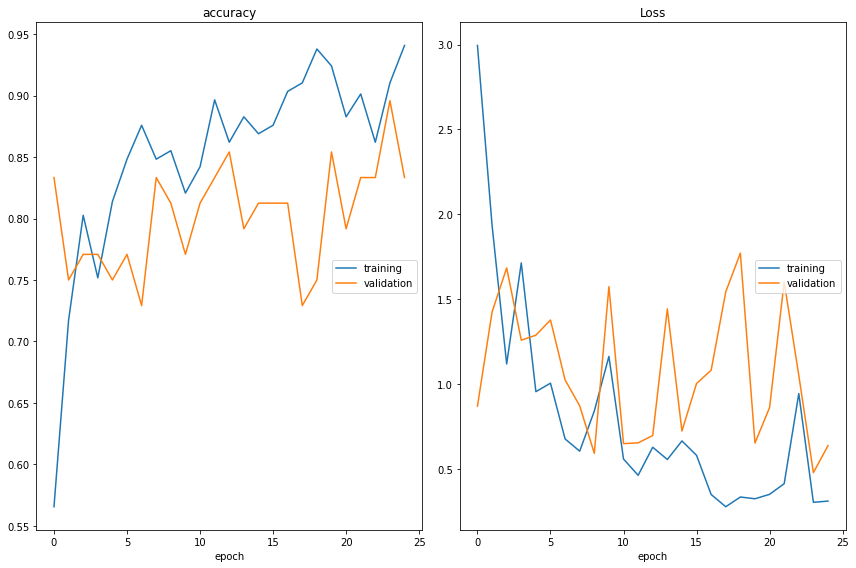

accuracy
	training         	 (min:    0.566, max:    0.941, cur:    0.941)
	validation       	 (min:    0.729, max:    0.896, cur:    0.833)
Loss
	training         	 (min:    0.276, max:    2.995, cur:    0.309)
	validation       	 (min:    0.477, max:    1.771, cur:    0.636)
19/19 [==============================] - 7s 330ms/step - loss: 0.3095 - accuracy: 0.9408 - val_loss: 0.6363 - val_accuracy: 0.8333


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot import PlotLossesKeras
from tensorflow.keras.optimizers import Adam


model.compile(
    optimizer=Adam(learning_rate=0.0001), # adam defaults to learning rate=0.001
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# ModelCheckpoint callback - save best weights after each epoch
checkpoint_weights_filepath = 'banana_v1.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_weights_filepath,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  verbose=1)

# Early Stopping callback - stops early if no improvement is noted, restoring best weights
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=7,  restore_best_weights=True)


n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE

history = model.fit(traingen,
                    validation_data=validgen,
                    steps_per_epoch=n_steps,
                    validation_steps=n_val_steps,
                    epochs=25,
                    callbacks=[checkpoint, PlotLossesKeras()]) #es,

# Testing

In [ ]:
# load best checkpoint version of model
model.load_weights(checkpoint_weights_filepath)

# save the entire model, not just the weights (so we can use it easily in the software later)
model.save('banana_v1.best.hdf5')

# run a prediction on the test data
predictions = model.predict(testgen)
predicted_classes = np.argmax(predictions, axis=1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

In [ ]:
# The functions provided in this block of code for results visualization are being used directly from author James McDermott at learndatasci.com
# https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/#ImplementationofaCNNinKeras

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx][0])/255)
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

Overall Categorical Accuracy: 90.38%


,Precision,Recall,F-Score,Support
green,0.888889,1.000000,0.941176,24.0
overripe,1.000000,0.777778,0.875000,9.0
ripe,0.888889,0.842105,0.864865,19.0


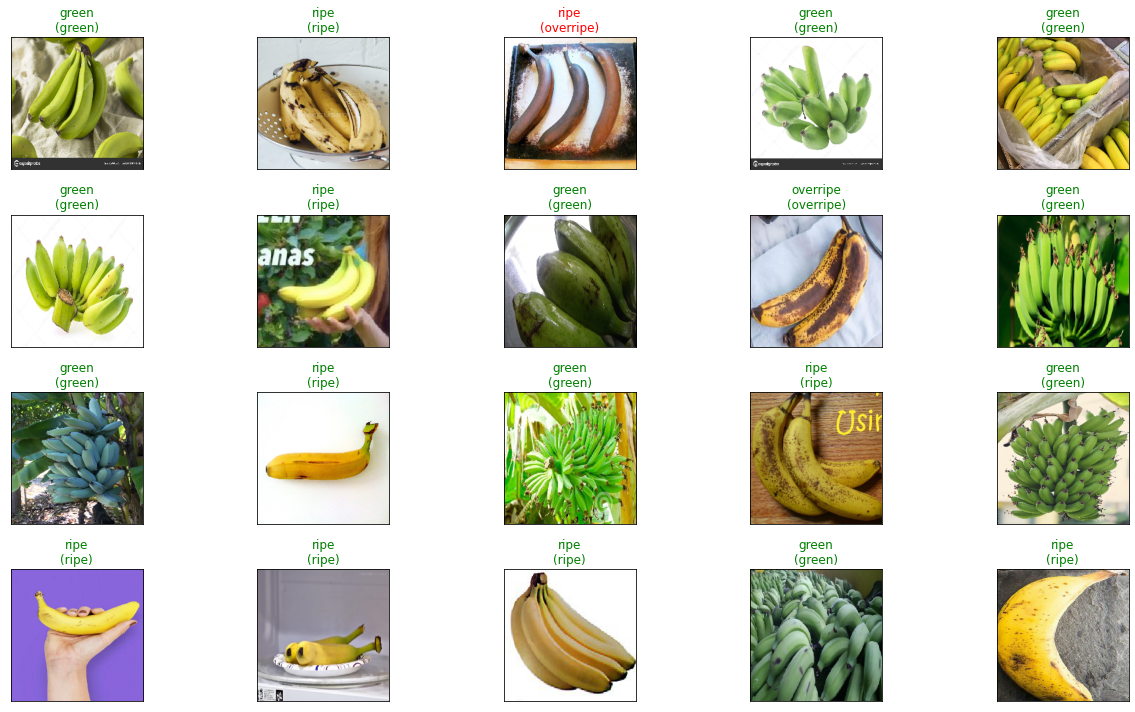

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)
display_results(true_classes, predicted_classes, class_indices.values())